In [1]:
!pip install kaggle
!pip install scikit-learn --upgrade
import glob
import zipfile
import pandas as pd
from google.colab import files
from sklearn.model_selection import train_test_split
 
# files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
 
!kaggle datasets download -d martj42/international-football-results-from-1872-to-2017
 
 
file = glob.glob('*.zip')[0]
with zipfile.ZipFile(file, 'r') as zip_ref:
  zip_ref.extractall('files')

international-football-results-from-1872-to-2017.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
df =  pd.read_csv('files/results.csv')
df.head(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [3]:
df.dtypes

date          object
home_team     object
away_team     object
home_score     int64
away_score     int64
tournament    object
city          object
country       object
neutral         bool
dtype: object

In [4]:
df.isna().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

In [5]:
df["Year"]=pd.to_datetime(df['date']).dt.year
df["Month"]=pd.to_datetime(df['date']).dt.month
df=df.drop(columns=['date'], axis=1)
df.head()

,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Year,Month
0,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,1872,11
1,England,Scotland,4,2,Friendly,London,England,False,1873,3
2,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,1874,3
3,England,Scotland,2,2,Friendly,London,England,False,1875,3
4,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,1876,3


In [6]:
df['total_score']=df['home_score']+df['away_score']
df.head()

,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Year,Month,total_score
0,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,1872,11,0
1,England,Scotland,4,2,Friendly,London,England,False,1873,3,6
2,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,1874,3,3
3,England,Scotland,2,2,Friendly,London,England,False,1875,3,4
4,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,1876,3,3


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Text(0.5, 1.0, 'TOP 10 TYPE OF MATCH TOURNAMENTS')

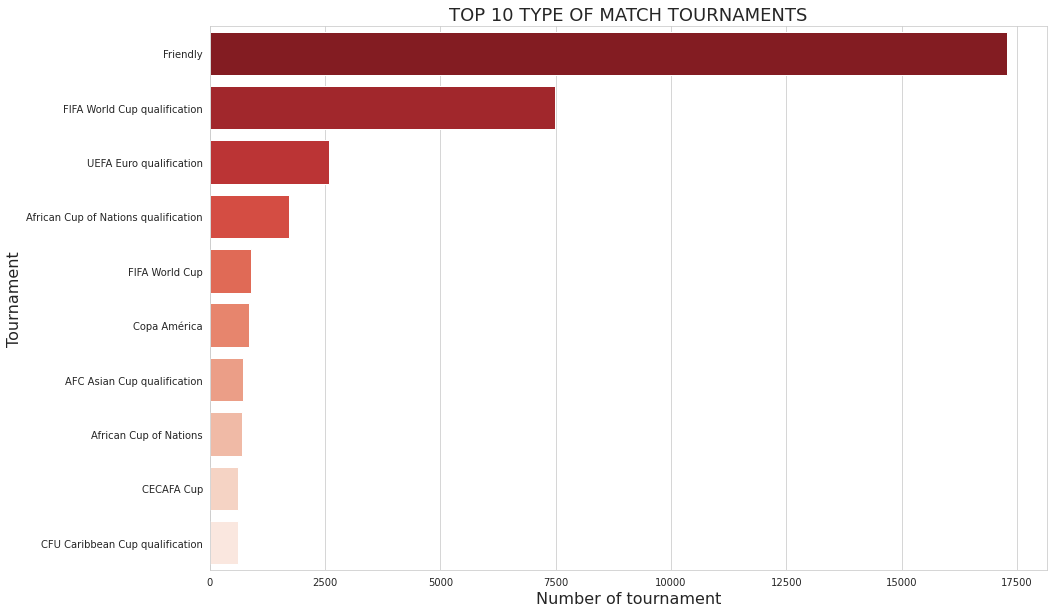

In [8]:
tournament = df['tournament'].value_counts()
tournament = tournament[:10]

plt.figure(figsize = (15,10))
sns.set_style("whitegrid")
ax = sns.barplot(y=tournament.index, x=tournament.values, palette="Reds_r", orient='h')
ax.set_ylabel('Tournament', size=16)
ax.set_xlabel('Number of tournament', size=16)
ax.set_title("TOP 10 TYPE OF MATCH TOURNAMENTS", fontsize=18)

Text(0.5, 1.0, 'TOP 10 OF GOAL AVERAGE PER MATCH')

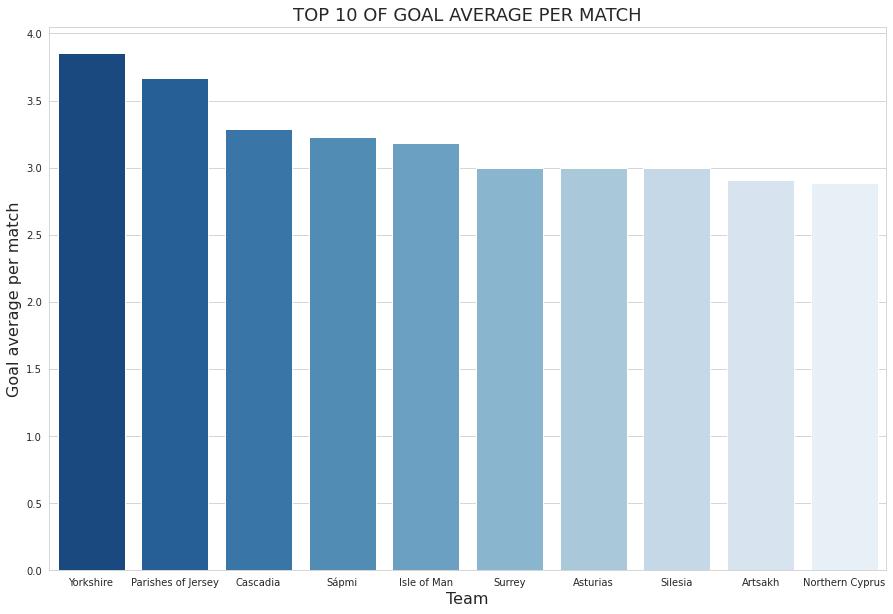

In [9]:
# create two dataframe for the home and away teams
home = df[['home_team', 'home_score']].rename(columns={'home_team':'team', 'home_score':'score'})
away = df[['away_team', 'away_score']].rename(columns={'away_team':'team', 'away_score':'score'})
# merge it into one
team_score = home.append(away).reset_index(drop=True)
# make an aggregation of the the score column group by the team
country_info = team_score.groupby('team')['score'].agg(['sum','count','mean']).reset_index()
country_info = country_info.rename(columns={'sum':'nb_goals', 'count':'nb_matches', 'mean':'goal_avg'})


plt.figure(figsize = (15,10))
sns.set_style("whitegrid")
plt_data = country_info.sort_values(by='goal_avg', ascending=False)[:10]
ax = sns.barplot(x="team", y="goal_avg", data=plt_data, palette="Blues_r")
ax.set_xlabel('Team', size=16)
ax.set_ylabel('Goal average per match', size=16)
ax.set_title("TOP 10 OF GOAL AVERAGE PER MATCH", fontsize=18)

Text(0.5, 1.0, 'TOP 10 OF NUMBER OF MATCHES')

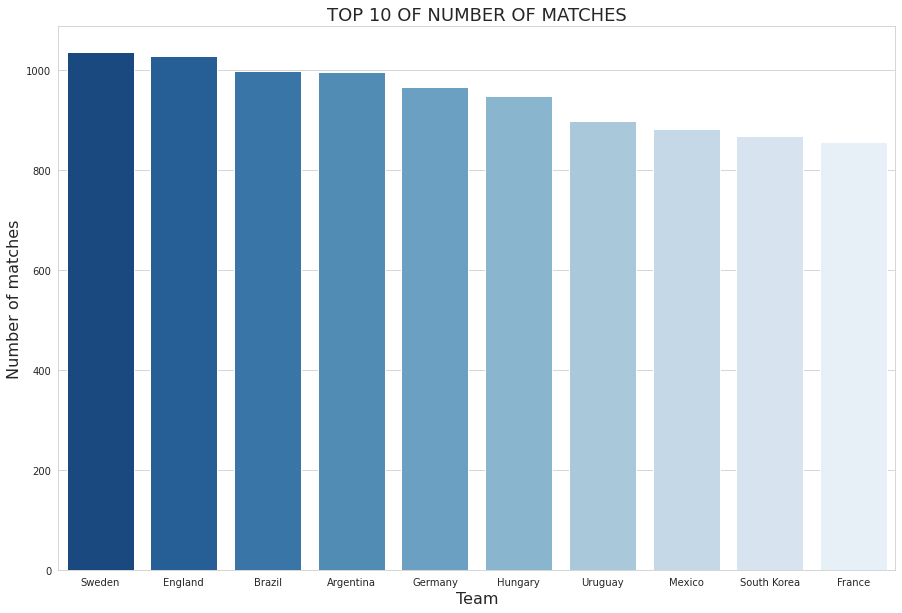

In [10]:
plt.figure(figsize = (15,10))
sns.set_style("whitegrid")
plt_data = country_info.sort_values(by='nb_matches', ascending=False)[:10]
ax = sns.barplot(x="team", y="nb_matches", data=plt_data, palette="Blues_r")
ax.set_xlabel('Team', size=16)
ax.set_ylabel('Number of matches', size=16)
ax.set_title("TOP 10 OF NUMBER OF MATCHES", fontsize=18)

Text(0.5, 1.0, 'TOP 10 OF NUMBER OF GOALS')

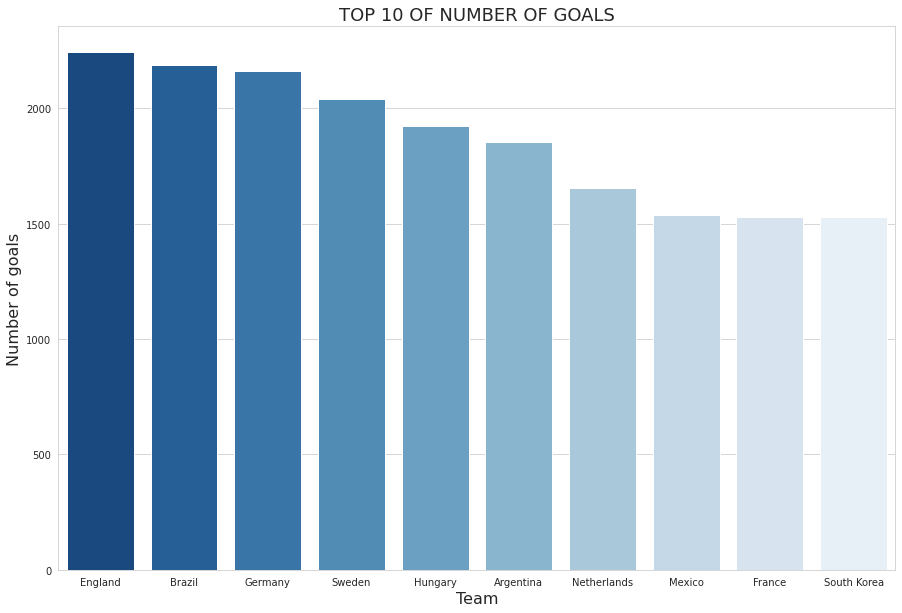

In [11]:
plt.figure(figsize = (15,10))
sns.set_style("whitegrid")
plt_data = country_info.sort_values(by='nb_goals', ascending=False)[:10]
ax = sns.barplot(x="team", y="nb_goals", data=plt_data, palette="Blues_r")
ax.set_xlabel('Team', size=16)
ax.set_ylabel('Number of goals', size=16)
ax.set_title("TOP 10 OF NUMBER OF GOALS", fontsize=18)

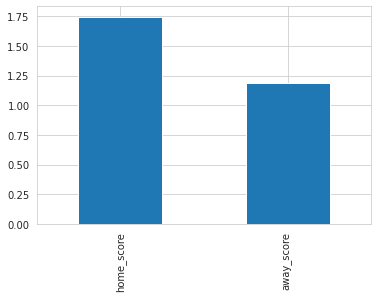

In [12]:
means = df[['home_score','away_score']].mean()
means.plot(kind='bar')

In [13]:
con=[(df['home_score']==df['away_score']),(df['home_score']>df['away_score']),(df['home_score']<df['away_score'])]
val=[0,1,2]
val2=['no_win',df['home_team'],df['away_team']]
df['result']=np.select(con,val)
df['who_win']=np.select(con,val2)
df.head()

,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Year,Month,total_score,result,who_win
0,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,1872,11,0,0,no_win
1,England,Scotland,4,2,Friendly,London,England,False,1873,3,6,1,England
2,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,1874,3,3,1,Scotland
3,England,Scotland,2,2,Friendly,London,England,False,1875,3,4,0,no_win
4,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,1876,3,3,1,Scotland


In [14]:
bestteam=df.groupby('who_win').sum()
bestteam=bestteam[['home_score','away_score','total_score']].sort_values(by=['total_score'],ascending=False)
bestteam=bestteam.drop(['no_win'])
bestteam.to_csv('q1.csv')

In [15]:
bestteam2=df.groupby('who_win').count()
bestteam2=bestteam2[['result']].sort_values(by=['result'],ascending=False)
bestteam2=bestteam2.drop(['no_win'])

bestteam2.to_csv('q2.csv')

In [16]:
def re_find(who_win):
    if "no_win" not in who_win.lower():
        return True
    return False
teams=df[['Year','who_win']]
teams2=teams[teams['who_win'].apply(re_find)]

list1=[]
list2=[]
list3=[]
b=teams2['Year'].count()
for i in range(0,b):
    list1.append(teams2['Year'].iloc[i])
    list2.append(teams2['who_win'].iloc[i])
    a=str(teams2['Year'].iloc[i])+teams2['who_win'].iloc[i]
    list3.append(a)
    
list_label = ["Year","who_win","Year_who_win"] 
list_col = [list1,list2,list3]       
zipped = zip(list_label,list_col) 
data_dict = dict(zipped)  

teams3 = pd.DataFrame(data_dict)
teams4=teams3.groupby('Year_who_win').count()
teams4=teams4[['who_win']].sort_values(by=['who_win'], ascending=False)
teams4.to_csv('q3.csv')

Text(0.5, 0, '')

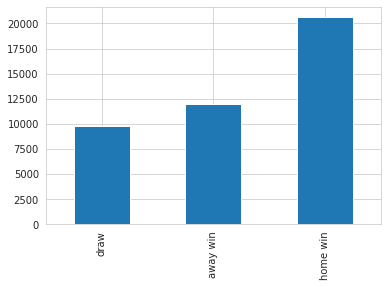

In [17]:
con=[(df['home_team']==df['who_win']),(df['away_team']==df['who_win'])]
val=['home_win','away_win']
val2=[1,1]
df['home_away_win']=np.select(con,val)
df['home_away_win2']=np.select(con,val2)

df1=df.groupby('home_away_win').count()
ax = df1[['who_win']].plot(kind='bar',legend=False, )
ax.set_xticklabels(['draw','away win','home win'])
ax.set_xlabel(None)

In [18]:
data_c = df.drop(df[df.country == df.home_team].index)
list1=[]
list2=[]
b=len(data_c.index)
for i in range(0,b):
    list1.append(data_c['country'].iloc[i])
    list2.append(1)

list_label = ["Country","Num"] 
list_col = [list1,list2]       
zipped = zip(list_label,list_col) 
data_dict = dict(zipped) 

data_c3 = pd.DataFrame(data_dict) 
data_c4=data_c3.groupby('Country').count()
data_c5=data_c4[['Num']]
data_c6=data_c5.sort_values(by=['Num'], ascending=False)
data_c6.to_csv('q4.csv')

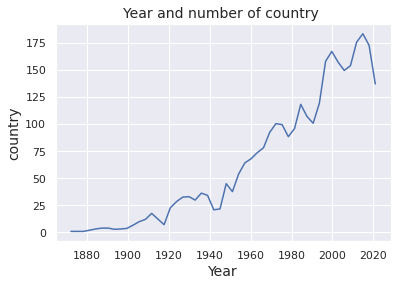

In [19]:
from scipy.interpolate import make_interp_spline


sns.set()
data_c=df[['Year','country']]
data_c = data_c.drop_duplicates()
data_c1=data_c.groupby('Year').count()


x_sm = np.array(data_c1.index)
y_sm = np.array(data_c1['country'])

x_smooth = np.linspace(x_sm.min(), x_sm.max(), 50)
y_smooth = make_interp_spline(x_sm, y_sm)(x_smooth)


plt.plot(x_smooth, y_smooth)
plt.title('Year and number of country ', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('country', fontsize=14)
plt.grid(True)
plt.show()

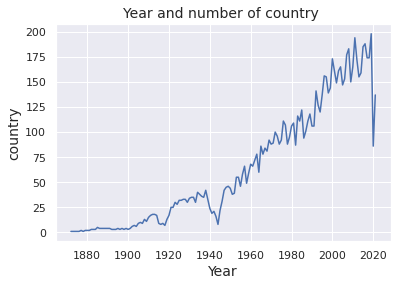

In [20]:
plt.plot(x_sm, y_sm)
plt.title('Year and number of country ', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('country', fontsize=14)
plt.grid(True)
plt.show()